<a href="https://colab.research.google.com/github/joahofmann/gcp-notebooks/blob/main/vertex_metrics_viz_run_compare_kfp_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Pipelines: Metrics visualization and run comparison using the KFP SDK

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/pipelines/metrics_viz_run_compare_kfp.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fvertex-ai-samples%2Fmain%2Fnotebooks%2Fofficial%2Fpipelines%2Fmetrics_viz_run_compare_kfp.ipynb">
      <img width="32px" src="https://cloud.google.com/ml-engine/images/colab-enterprise-logo-32px.png" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/pipelines/metrics_viz_run_compare_kfp.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br>
      View on GitHub
    </a>
  </td>
  <td style="text-align: center">
<a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/pipelines/metrics_viz_run_compare_kfp.ipynb" target='_blank'>
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br>
      Open in Vertex AI Workbench
     </a>
  </td>
</table>
<br/><br/><br/>

## Overview

This notebook shows how to use [the Kubeflow Pipelines (KFP) SDK](https://www.kubeflow.org/docs/components/pipelines/) to build [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines) that generate model metrics and metrics visualizations, and comparing pipeline runs.

Learn more about [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction).

### Objective

In this tutorial, you learn how to use the KFP SDK for Python to build pipelines that generate evaluation metrics.

This tutorial uses the following Vertex AI services:

- Vertex AI Pipelines

The steps performed include:

- Create KFP components:
    - Generate ROC curve and confusion matrix visualizations for classification results
    - Write metrics
- Create KFP pipelines.
- Execute KFP pipelines
- Compare metrics across pipeline runs

### Datasets

The dataset used for this tutorial is the [Wine dataset](https://archive.ics.uci.edu/ml/datasets/wine) from [Scikit-learn builtin datasets](https://scikit-learn.org/stable/datasets.html).

The dataset predicts the origin of a wine.

The dataset used for this tutorial is the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) from [Scikit-learn builtin datasets](https://scikit-learn.org/stable/datasets.html).

The dataset predicts the type of Iris flower species from a class of three species: setosa, virginica, or versicolor.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Get started

### Install Vertex AI SDK for Python and other required packages

In [1]:
import os

! pip3 install --upgrade --quiet google-cloud-aiplatform \
                                 google-cloud-storage \
                                 kfp \
                                 google-cloud-pipeline-components

if os.getenv("IS_TESTING"):
    ! pip3 install --upgrade matplotlib $USER_FLAG -q

### Restart runtime (Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab.

In [2]:
import sys

if "google.colab" in sys.modules:

    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>

### Authenticate your notebook environment (Colab only)

Authenticate your environment on Google Colab.

In [ ]:
import sys

if "google.colab" in sys.modules:

    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [2]:
PROJECT_ID = "vertex-test-id"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

#### UUID

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a uuid for each instance session, and append it onto the name of resources you create in this tutorial.

In [3]:
import random
import string


# Generate a uuid of a specifed length(default=8)
def generate_uuid(length: int = 8) -> str:
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=length))


UUID = generate_uuid()

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [4]:
BUCKET_URI = f"gs://test-bucket-name-{PROJECT_ID}-unique"  # @param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [5]:
! gsutil mb -l {LOCATION} -p {PROJECT_ID} {BUCKET_URI}

Creating gs://test-bucket-name-vertex-test-id-unique/...
ServiceException: 409 A Cloud Storage bucket named 'test-bucket-name-vertex-test-id-unique' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


### Service Account

**If you don't know your service account**, try to get your service account using `gcloud` command by executing the second cell below.

In [6]:
SERVICE_ACCOUNT = "219162896674-compute@developer.gserviceaccount.com"  # @param {type:"string"}

In [7]:
import sys

IS_COLAB = "google.colab" in sys.modules

if (
    SERVICE_ACCOUNT == ""
    or SERVICE_ACCOUNT is None
    or SERVICE_ACCOUNT == "[your-service-account]"
):
    # Get your service account from gcloud
    if not IS_COLAB:
        shell_output = !gcloud auth list 2>/dev/null
        SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()

    if IS_COLAB:
        shell_output = ! gcloud projects describe  $PROJECT_ID
        project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
        SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"

    print("Service Account:", SERVICE_ACCOUNT)

#### Set service account access for Vertex AI Pipelines

Run the following commands to grant your service account access to read and write pipeline artifacts in the bucket that you created in the previous step. You only need to run these once per service account.

In [8]:
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator $BUCKET_URI

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer $BUCKET_URI

No changes made to gs://test-bucket-name-vertex-test-id-unique/
No changes made to gs://test-bucket-name-vertex-test-id-unique/


### Import libraries and define constants

In [9]:
import google.cloud.aiplatform as aip
from kfp import compiler, dsl
from kfp.dsl import ClassificationMetrics, Metrics, Output, component

#### Vertex AI constants

Setup up the following constants for Vertex AI pipelines:
- `PIPELINE_NAME`: Set name for the pipeline.
- `PIPELINE_ROOT`: Cloud Storage bucket path to store pipeline artifacts.

In [10]:
PIPELINE_NAME = "metrics-pipeline-v2"
PIPELINE_ROOT = "{}/pipeline_root/iris".format(BUCKET_URI)

## Initialize Vertex AI SDK for Python

To get started using Vertex AI, you must [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

In [11]:
aip.init(project=PROJECT_ID, staging_bucket=BUCKET_URI)

### Define pipeline components using scikit-learn

In this section, you define some Python function-based components that use scikit-learn to train some classifiers and produce evaluations that can be visualized.

Note the use of the `@component()` decorator in the definitions below. Optionally, you can set a list of packages for the component to install. That is, list the base image to use (the default is a Python 3.7 image), and the name of a component YAML file to generate, so that the component definition can be shared and reused.

#### Define wine_classification component

The first component shows how to visualize an *ROC curve*.
Note that the function definition includes an output called `wmetrics`, of type `Output[ClassificationMetrics]`. You can visualize the metrics in the pipeline's user interface in the Google Cloud console.

To do so, this example uses the artifact's `log_roc_curve()` method. This method takes input arrays with the false positive rates, true positive rates, and thresholds, as [generated by the `sklearn.metrics.roc_curve` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html).

When you evaluate the cell below, a task factory function called `wine_classification` is created that is used to construct the pipeline definition.  In addition, a component YAML file is created, which can be shared and loaded via file or URL to create the same task factory function.

In [12]:
@component(
    packages_to_install=["scikit-learn==1.2", "numpy==1.26.4"], base_image="python:3.9"
)
def wine_classification(wmetrics: Output[ClassificationMetrics]):
    from sklearn.datasets import load_wine
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import roc_curve
    from sklearn.model_selection import cross_val_predict, train_test_split

    X, y = load_wine(return_X_y=True)
    # Binary classification problem for label 1.
    y = y == 1

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    rfc = RandomForestClassifier(n_estimators=10, random_state=42)
    rfc.fit(X_train, y_train)
    y_scores = cross_val_predict(rfc, X_train, y_train, cv=3, method="predict_proba")
    fpr, tpr, thresholds = roc_curve(
        y_true=y_train, y_score=y_scores[:, 1], pos_label=True
    )
    wmetrics.log_roc_curve(fpr, tpr, thresholds)


compiler.Compiler().compile(wine_classification, "wine_classification_component.yaml")

#### Define iris_sgdclassifier component

The second component shows how to visualize a *confusion matrix*, in this case for a model trained using `SGDClassifier`.

As with the previous component, you create a `metricsc` output artifact of type `Output[ClassificationMetrics]`.  Then, use the artifact's `log_confusion_matrix` method to visualize the confusion matrix results, as generated by the [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function.

In [13]:
@component(
    packages_to_install=["scikit-learn==1.2", "numpy==1.26.4"], base_image="python:3.9"
)
def iris_sgdclassifier(
    test_samples_fraction: float,
    metricsc: Output[ClassificationMetrics],
):
    from sklearn import datasets, model_selection
    from sklearn.linear_model import SGDClassifier
    from sklearn.metrics import confusion_matrix

    iris_dataset = datasets.load_iris()
    train_x, test_x, train_y, test_y = model_selection.train_test_split(
        iris_dataset["data"],
        iris_dataset["target"],
        test_size=test_samples_fraction,
    )

    classifier = SGDClassifier()
    classifier.fit(train_x, train_y)
    predictions = model_selection.cross_val_predict(classifier, train_x, train_y, cv=3)
    metricsc.log_confusion_matrix(
        ["Setosa", "Versicolour", "Virginica"],
        confusion_matrix(
            train_y, predictions
        ).tolist(),  # .tolist() to convert np array to list.
    )

#### Define iris_logregression component

The third component also uses the "iris" dataset, but trains a `LogisticRegression` model.  It logs model `accuracy` in the `metrics` output artifact.

In [14]:
@component(
    packages_to_install=["scikit-learn==1.2", "numpy==1.26.4"],
    base_image="python:3.9",
)
def iris_logregression(
    input_seed: int,
    split_count: int,
    metrics: Output[Metrics],
):
    from sklearn import datasets, model_selection
    from sklearn.linear_model import LogisticRegression

    # Load digits dataset
    iris = datasets.load_iris()
    # # Create feature matrix
    X = iris.data
    # Create target vector
    y = iris.target
    # test size
    test_size = 0.20

    # cross-validation settings
    kfold = model_selection.KFold(
        n_splits=split_count, random_state=input_seed, shuffle=True
    )
    # Model instance
    model = LogisticRegression()
    scoring = "accuracy"
    results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    print(f"results: {results}")

    # split data
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=test_size, random_state=input_seed
    )
    # fit model
    model.fit(X_train, y_train)

    # accuracy on test set
    result = model.score(X_test, y_test)
    print(f"result: {result}") # Added print statement
    metrics.log_metric("accuracy", (result * 100.0))

### Define the pipeline

Next, define a simple pipeline that uses the above components.

**Note:** In the `@dsl.pipeline` decorator, you define `PIPELINE_ROOT` as the Cloud Storage path that's used as root folder. You can choose to skip it, but you have to provide it when creating the pipeline run.

In [15]:
@dsl.pipeline(
    # Default pipeline root. You can override it when submitting the pipeline.
    pipeline_root=PIPELINE_ROOT,
    # A name for the pipeline.
    name="metrics-pipeline-v2",
)
def pipeline(seed: int, splits: int):
    wine_classification_op = wine_classification()  # noqa: F841
    iris_logregression_op = iris_logregression(  # noqa: F841
        input_seed=seed, split_count=splits
    )
    iris_sgdclassifier_op = iris_sgdclassifier(test_samples_fraction=0.3)  # noqa: F841

## Compile the pipeline

Next, compile the pipeline.

In [16]:
compiler.Compiler().compile(
    pipeline_func=pipeline,
    package_path="tabular_classification_pipeline.yaml",
)

## Run the pipeline

Next, run the pipeline.

In [ ]:
DISPLAY_NAME = "iris_" + UUID

job1 = aip.PipelineJob(
    display_name=DISPLAY_NAME,
    template_path="tabular_classification_pipeline.yaml",
    job_id=f"tabular-classification-v2{UUID}-1",
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"seed": 7, "splits": 10},
)

job1.run()

Click on the generated link to see your run in the Google Cloud console.

<!-- It should look something like this as it is running:

<a href="https://storage.googleapis.com/amy-jo/images/mp/automl_tabular_classif.png" target="_blank"><img src="https://storage.googleapis.com/amy-jo/images/mp/automl_tabular_classif.png" width="40%"/></a> -->

In the Google Cloud console, many of the pipeline DAG nodes expand or collapse when you click them.

## Comparing pipeline runs in the Google Cloud console

Next, generate another pipeline run that uses a different `seed` and `split` for the `iris_logregression` step.

Pass the input parameters required for the pipeline and run it. The defined pipeline takes the following parameters:

- `pipeline_root`: Specify a Cloud Storage URI that your pipelines service account can access. The artifacts of your pipeline runs are stored within the pipeline root.
- `display_name`: The name of the pipeline, that shows up in the Google Cloud console.
- `parameter_values`: The pipeline parameters to pass to this run. For example, create a dict() with the parameter names as the dictionary keys and the parameter values as the dictionary values.
- `job_id`: A unique identifier for this pipeline run. If the job ID is not specified, Vertex AI Pipelines creates a job ID for you using the pipeline name and the timestamp of when the pipeline run was started.
- `template_path`: Complete pipeline path

In [ ]:
job2 = aip.PipelineJob(
    display_name="iris_" + UUID,
    template_path="tabular_classification_pipeline.yaml",
    job_id=f"tabular-classification-pipeline-v2{UUID}-2",
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"seed": 5, "splits": 7},
)

job2.run()

When both pipeline runs have finished, compare their results by navigating to the pipeline runs list in the Google Cloud console, selecting both of them, and clicking **COMPARE** at the top of the Console panel.

## Compare the parameters and metrics of the pipelines run from their tracked metadata

Next, you use the Vertex AI SDK for Python to compare the parameters and metrics of the pipeline runs. Wait until the pipeline runs have finished to run the next cell.

In [ ]:
pipeline_df = aip.get_pipeline_df(pipeline=PIPELINE_NAME)
print(pipeline_df.head(2))

### Plot parallel coordinates of parameters and metrics

With the metric and parameters in a dataframe, you can perform further analysis to extract useful information. The following example compares data from each run using a parallel coordinate plot.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.cloud.aiplatform.compat.types import pipeline_state # Import PipelineState from correct location


plt.rcParams["figure.figsize"] = [15, 5]

pipeline_df["param.input:seed"] = pipeline_df["param.input:seed"].astype(np.float16)
pipeline_df["param.input:splits"] = pipeline_df["param.input:splits"].astype(np.float16)

# Get the list of pipeline jobs again to access their details
jobs = aip.PipelineJob.list(filter=f'display_name="{DISPLAY_NAME}"')

# Create a dictionary to store accuracy metrics by run_name
accuracy_metrics = {}

for job in jobs:
    # Check if the job state indicates success
    if job.state == pipeline_state.PipelineState.PIPELINE_STATE_SUCCEEDED: # Use the imported PipelineState
        # Access the task details to get the metrics
        # The task name for iris_logregression component is typically the function name
        task_name = "iris_logregression"
        if task_name in job.task_details:
            task = job.task_details[task_name]
            if task.execution and task.execution.metadata and 'metrics' in task.execution.metadata:
                metrics_metadata = task.execution.metadata['metrics']
                if isinstance(metrics_metadata, dict) and 'accuracy' in metrics_metadata:
                     # The accuracy metric is stored under 'accuracy' key
                    accuracy_metrics[job.display_name] = metrics_metadata['accuracy']
                elif isinstance(metrics_metadata, list):
                    for item in metrics_metadata:
                        if isinstance(item, dict) and item.get('name') == 'accuracy':
                            accuracy_metrics[job.display_name] = item.get('number_value')
                            break


# Add the accuracy metrics to the pipeline_df DataFrame
pipeline_df['metric.accuracy'] = pipeline_df['run_name'].map(accuracy_metrics)


ax = pd.plotting.parallel_coordinates(
    pipeline_df.reset_index(level=0),
    "run_name",
    cols=["param.input:seed", "param.input:splits", "metric.accuracy"],
)
ax.set_yscale("symlog")
ax.legend(bbox_to_anchor=(1.0, 0.5))

### Plot ROC curve and calculate AUC number

In addition to basic metrics, you can extract complex metrics and perform further analysis using the `get_pipeline_df` method.

In [21]:
try:
    df = pd.DataFrame(pipeline_df["metric.confidenceMetrics"][0])
    auc = np.trapz(df["recall"], df["falsePositiveRate"])
    plt.plot(df["falsePositiveRate"], df["recall"], label="auc=" + str(auc))
    plt.legend(loc=4)
    plt.show()
except Exception as e:
    print(e)

'metric.confidenceMetrics'


# Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial.

In [22]:
delete_bucket = False

job1.delete()
job2.delete()

if delete_bucket:
    ! gsutil rm -r $BUCKET_URI

! rm -rf tabular_classification_pipeline.yaml

In [ ]:
DISPLAY_NAME = "iris_" + UUID

job1 = aip.PipelineJob(
    display_name=DISPLAY_NAME,
    template_path="tabular_classification_pipeline.yaml",
    job_id=f"tabular-classification-v2{UUID}-1",
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"seed": 7, "splits": 10},
)

job1.run()

In [17]:
DISPLAY_NAME = "iris_" + UUID

job1 = aip.PipelineJob(
    display_name=DISPLAY_NAME,
    template_path="tabular_classification_pipeline.yaml",
    job_id=f"tabular-classification-v2{UUID}-1",
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"seed": 7, "splits": 10},
)

job1.run()

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob


In [ ]:
DISPLAY_NAME = "iris_" + UUID

job1 = aip.PipelineJob(
    display_name=DISPLAY_NAME,
    template_path="tabular_classification_pipeline.yaml",
    job_id=f"tabular-classification-v2{UUID}-1",
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"seed": 7, "splits": 10},
)

job1.run()

In [ ]:
DISPLAY_NAME = "iris_" + UUID

job1 = aip.PipelineJob(
    display_name=DISPLAY_NAME,
    template_path="tabular_classification_pipeline.yaml",
    job_id=f"tabular-classification-v2{UUID}-1-rerun", # Modified job_id
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"seed": 7, "splits": 10},
)

job1.run()

In [18]:
job2 = aip.PipelineJob(
    display_name="iris_" + UUID,
    template_path="tabular_classification_pipeline.yaml",
    job_id=f"tabular-classification-pipeline-v2{UUID}-2",
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"seed": 5, "splits": 7},
)

job2.run()

In [19]:
pipeline_df = aip.get_pipeline_df(pipeline=PIPELINE_NAME)
print(pipeline_df.head(2))

         pipeline_name                                      run_name  \
0  metrics-pipeline-v2  tabular-classification-pipeline-v2tg5g39cv-2   
1  metrics-pipeline-v2           tabular-classification-v2tg5g39cv-1   

                     param.vmlmd_lineage_integration  param.input:seed  \
0  {'pipeline_run_component': {'parent_task_names...               5.0   
1  {'pipeline_run_component': {'parent_task_names...               7.0   

   param.input:splits  
0                 7.0  
1                10.0  


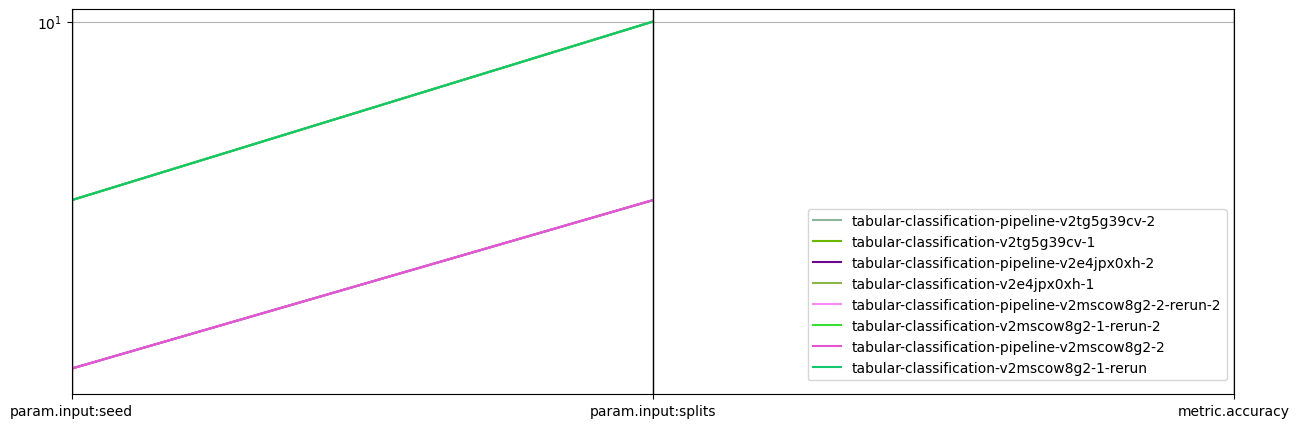

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.cloud.aiplatform.compat.types import pipeline_state # Import PipelineState from correct location

plt.rcParams["figure.figsize"] = [15, 5]

pipeline_df["param.input:seed"] = pipeline_df["param.input:seed"].astype(np.float16)
pipeline_df["param.input:splits"] = pipeline_df["param.input:splits"].astype(np.float16)

# Get the list of pipeline jobs again to access their details
jobs = aip.PipelineJob.list(filter=f'display_name="{DISPLAY_NAME}"')

# Create a dictionary to store accuracy metrics by run_name
accuracy_metrics = {}

for job in jobs:
    # Check if the job state indicates success
    if job.state == pipeline_state.PipelineState.PIPELINE_STATE_SUCCEEDED: # Use the imported PipelineState
        # Access the task details to get the metrics
        # The task name for iris_logregression component is typically the function name
        task_name = "iris_logregression"
        if task_name in job.task_details:
            task = job.task_details[task_name]
            if task.execution and task.execution.metadata and 'metrics' in task.execution.metadata:
                metrics_metadata = task.execution.metadata['metrics']
                if isinstance(metrics_metadata, dict) and 'accuracy' in metrics_metadata:
                     # The accuracy metric is stored under 'accuracy' key
                    accuracy_metrics[job.display_name] = metrics_metadata['accuracy']
                elif isinstance(metrics_metadata, list):
                    for item in metrics_metadata:
                        if isinstance(item, dict) and item.get('name') == 'accuracy':
                            accuracy_metrics[job.display_name] = item.get('number_value')
                            break


# Add the accuracy metrics to the pipeline_df DataFrame
# Use job.display_name as the key for mapping since accuracy_metrics uses display_name
pipeline_df['metric.accuracy'] = pipeline_df['run_name'].map(accuracy_metrics)


ax = pd.plotting.parallel_coordinates(
    pipeline_df.reset_index(level=0),
    "run_name",
    cols=["param.input:seed", "param.input:splits", "metric.accuracy"],
)
ax.set_yscale("symlog")
ax.legend(bbox_to_anchor=(1.0, 0.5))

In [ ]:
compiler.Compiler().compile(
    pipeline_func=pipeline,
    package_path="tabular_classification_pipeline.yaml",
)

job1 = aip.PipelineJob(
    display_name="iris_" + UUID,
    template_path="tabular_classification_pipeline.yaml",
    job_id=f"tabular-classification-v2{UUID}-1-rerun-2",
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"seed": 7, "splits": 10},
)

job1.run()

job2 = aip.PipelineJob(
    display_name="iris_" + UUID,
    template_path="tabular_classification_pipeline.yaml",
    job_id=f"tabular-classification-pipeline-v2{UUID}-2-rerun-2",
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"seed": 5, "splits": 7},
)

job2.run()

pipeline_df = aip.get_pipeline_df(pipeline=PIPELINE_NAME)
print(pipeline_df.head(2))

In [ ]:
jobs = aip.PipelineJob.list(filter=f'display_name="{DISPLAY_NAME}"')
for job in jobs:
    job_id = job.name.split('/')[-1] # Extract job_id from the name attribute
    print(f"Job Name: {job.display_name}, Job ID: {job_id}, State: {job.state}")